In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# CartPole Value Learning

In this notebook we look at just a Critic model for the classic Cart-Pole reinforcement learning task.  That is, we're just going to have the system behave randomly, and we're just learning the value function:  $V(s_t) = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... = r_t + \gamma V(s_{t+1})$.  That is, the system should learn how good the current state is and this evaluation will get closer to zero as we get closer to having the pole fall over.  (In the Cart-Pole task you are moving a cart back and forth, and there's a pole sticking up on the cart and you're trying to not have the pole fall over.  The reward is 1 if the pole hasn't fallen over yet, and it's 0 when it falls over.)

The following is a big block of code that defines the task (using the OpenAI gym implementation), and defines a nengo model of the value part of the task.  It's using the `pytry` system that I talked about here https://github.com/neuromorphs/grill-eprop-lsnn/blob/master/rl/Using%20pytry%20to%20explore%20parameters.ipynb and for more information on this approach to Actor-Critic RL, see https://github.com/neuromorphs/grill-eprop-lsnn/blob/master/rl/Implementing%20Actor-Critic%20RL%20in%20Nengo.ipynb

The code defines a whole bunch of parameters for adjusting things in the model, which we will look at below.


In [56]:
import nengo_spa as spa
import nengo
import gym
import logging
gym.logger.set_level(logging.ERROR)  # suppress the error of running the model after it's done
import numpy as np
import pytry

class CartPoleTrial(pytry.PlotTrial):
    def params(self):
        self.param('time to run', T=10)
        self.param('gate error signal', gate_error=False)
        self.param('gate future value signal', gate_future_value=False)
        self.param('RL discount rate', gamma=0.9)
        self.param('use SSP representation', use_ssp=False)
        self.param('number of neurons', n_neurons=1000)
        self.param('learning rate', learning_rate=1e-4)
        self.param('SSP scale', ssp_scale=1)
        self.param('normalize state', normalize_state=False)
        self.param('sample encoders from represented space', sample_encoders=False)
        self.param('multiplicative SSP', ssp_multiply=False)
        self.param('cosine intercepts', cosine_intercepts=False)
        
    def evaluate(self, p, plt):
        # define the OpenAI gym environment interface
        class CartPole:
            def __init__(self, done_time=20, reset_time=20, seed=None):
                self.env = gym.make('CartPole-v0')
                self.env.seed(seed)
                self.env.reset()
                self.reset_time = reset_time
                self.done_time = done_time
                self.reset_counter = 0
                self.rng = np.random.RandomState(seed=seed)
                if p.normalize_state:
                    self.state_scale = 1.0/np.array([0.22055888, 0.70636221, 0.44982735, 1.8954963])
                else:
                    self.state_scale = np.ones(4)
                    
            def update(self, t, x):
                is_done = 0 < self.reset_counter <= self.done_time
                if self.reset_counter > 0:
                    reward = 1
                    if self.reset_counter > self.reset_time:
                        self.env.step(self.env.action_space.sample())
                        reward = 0
                    if self.reset_counter == self.reset_time:
                        self.env.reset()
                    self.reset_counter -= 1
                else:
                    p = np.exp(x)/sum(np.exp(x))
                    action = self.rng.choice([0,1], p=p)
                    obs, reward, done, info = self.env.step(action)
                    if done:
                        self.reset_counter = self.reset_time + self.done_time
                return np.hstack([self.env.state*self.state_scale, [reward, is_done]])
        
        # choose the style of representation to use
        if p.use_ssp:
            D = 128
            vocab = spa.Vocabulary(D)
            vocab.populate('X.unitary().nondegenerate()')
            vocab.populate('DX.unitary().nondegenerate()')
            vocab.populate('A.unitary().nondegenerate()')
            vocab.populate('DA.unitary().nondegenerate()')
            X = vocab.parse('X')
            DX = vocab.parse('DX')
            A = vocab.parse('A')
            DA = vocab.parse('DA')

            if p.ssp_multiply:
                def convert(x):
                    return (X**(x[0]*p.ssp_scale)*DX**(x[1])*A**(x[2]*p.ssp_scale)*DA**(x[3])).v
            else:
                def convert(x):
                    return (X**(x[0]*p.ssp_scale)+DX**(x[1])+A**(x[2]*p.ssp_scale)+DA**(x[3])).v
        else:
            def convert(x):
                return x
            

        # define the nengo model
        env = CartPole(seed=p.seed)
        model = nengo.Network()
        with model:
            cp = nengo.Node(env.update, size_in=2, size_out=6)
            p_env = nengo.Probe(cp)

                
            ens = nengo.Ensemble(n_neurons=p.n_neurons, 
                                 dimensions=D if p.use_ssp else 4,
                                 radius=1 if p.use_ssp else 2,
                                 neuron_type=nengo.RectifiedLinear())
            
            if p.use_ssp and p.sample_encoders:
                encoders = []
                for i in range(ens.n_neurons):
                    x = np.random.uniform(-1, 1, size=4)
                    e = convert([x[0]*2, x[1]*2, x[2]*2, x[3]*2])
                    encoders.append(e)
                ens.encoders = np.array(encoders)
                
              
            if p.cosine_intercepts:
                ens.intercepts = nengo.dists.CosineSimilarity(ens.dimensions+2)
            nengo.Connection(cp[:4], ens, function=convert, synapse=None)
                
            v = nengo.Node(None, size_in=1)
            c = nengo.Connection(ens.neurons, v, transform=np.zeros((1, ens.n_neurons)), 
                                 learning_rule_type=nengo.PES(learning_rate=p.learning_rate, pre_synapse=0),
                                 synapse=None)


            error = nengo.Node(None, size_in=1)
            nengo.Connection(cp[4], error, transform=-1, synapse=0)
            nengo.Connection(v, error, transform=1, synapse=0)

            if p.gate_future_value:
                gated_value = nengo.Node(lambda t, x: x[0] if (x[1]==0) else 0, size_in=2, size_out=1)
                nengo.Connection(v, gated_value[0], synapse=None)
                nengo.Connection(cp[5], gated_value[1], synapse=None)
                nengo.Connection(gated_value, error, transform=-p.gamma, synapse=None)
            else:
                nengo.Connection(v, error, transform=-p.gamma, synapse=None)

            if p.gate_error:
                gate = nengo.Node(lambda t, x: x[0] if (x[1]==0) else 0, size_in=2, size_out=1)
                nengo.Connection(error, gate[0], synapse=None)
                nengo.Connection(cp[5], gate[1], synapse=None)
                nengo.Connection(gate, c.learning_rule, transform=1, synapse=None)
            else:
                nengo.Connection(error, c.learning_rule, transform=1, synapse=None)

            p_v = nengo.Probe(v)

        # run the model
        sim = nengo.Simulator(model, dt=0.01)
        sim.run(p.T)
        
        # make the summary plot, if asked
        if plt:
            v = sim.data[p_v]
            x = np.arange(40)-20

            reward = sim.data[p_env][:,4]
            align = np.where(np.diff(reward) == -1)[0]
            groups = np.linspace(0, len(v), 5).astype(int)

            plt.figure(figsize=(14,3))
            for index in range(4):
                total = []
                ax = plt.subplot(1, 4, index+1, sharey=ax if index>0 else None)
                for i in align:
                    if groups[index]<i<groups[index+1]:
                        vv = v[i-20:i+20,0].copy()
                        if len(vv)!=40:
                            continue
                        rr = reward[i-20:i+10]
                        vv[:20][rr[:20]<1] = np.nan
                        plt.plot(x, vv, alpha=0.2)
                        total.append(vv)
                plt.plot(x, np.nanmean(total, axis=0), c='k', lw=3, label='mean')

                plt.legend()
                plt.axvline(0)
                plt.title('steps %d-%d\n(N=%d)' % (groups[index], groups[index+1], len(total)))
            plt.tight_layout()
            ylim = plt.ylim()
            plt.ylim(0, ylim[1])
            
        # return the raw environment data and the decoded value
        return dict(v=sim.data[p_v], env=sim.data[p_env])

There's lots of parameters there, but here's a quick summary of them

In [57]:
print(CartPoleTrial().show_params())

                T: time to run (default=10)
cosine_intercepts: cosine intercepts (default=False)
            gamma: RL discount rate (default=0.9)
       gate_error: gate error signal (default=False)
gate_future_value: gate future value signal (default=False)
    learning_rate: learning rate (default=0.0001)
        n_neurons: number of neurons (default=1000)
  normalize_state: normalize state (default=False)
  sample_encoders: sample encoders from represented space (default=False)
             seed: random number seed (default=1)
     ssp_multiply: multiplicative SSP (default=False)
        ssp_scale: SSP scale (default=1)
          use_ssp: use SSP representation (default=False)
         data_dir: data directory (default='data')
    data_filename: filename for data (default='')
      data_format: data file format [txt,npz] (default='txt')
              plt: display plot (default=False)
      plt_overlay: show overlay on plot (default=False)
         plt_save: save plot (default=False

Now let's try running the model.  With the default parameters it is doing things in the simplest way possible -- we're just feeding the raw sensory data into the neurons, and learning the $V(s)$ function from that.

In [33]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Now let's plot that data.

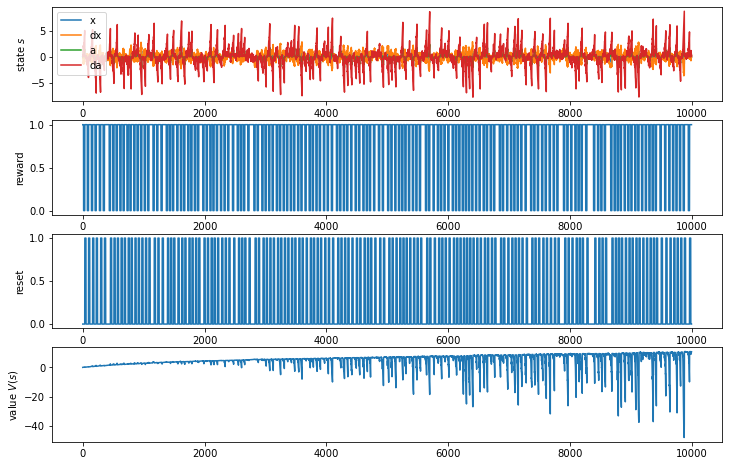

In [34]:
plt.figure(figsize=(12,8))
plt.subplot(4, 1, 1)
plt.plot(r['env'][:,0], label='x')
plt.plot(r['env'][:,1], label='dx')
plt.plot(r['env'][:,2], label='a')
plt.plot(r['env'][:,3], label='da')
plt.legend()
plt.ylabel('state $s$')
plt.subplot(4, 1, 2)
plt.plot(r['env'][:,4], label='reward')
plt.ylabel('reward')
plt.subplot(4, 1, 3)
plt.plot(r['env'][:,5], label='reset')
plt.ylabel('reset')
plt.subplot(4, 1, 4)
plt.plot(r['v'], label='value')
plt.ylabel('value $V(s)$')
plt.show()


Well, something seems to be happening there, but it's hard to see.  Let's zoom in on the last few trials.

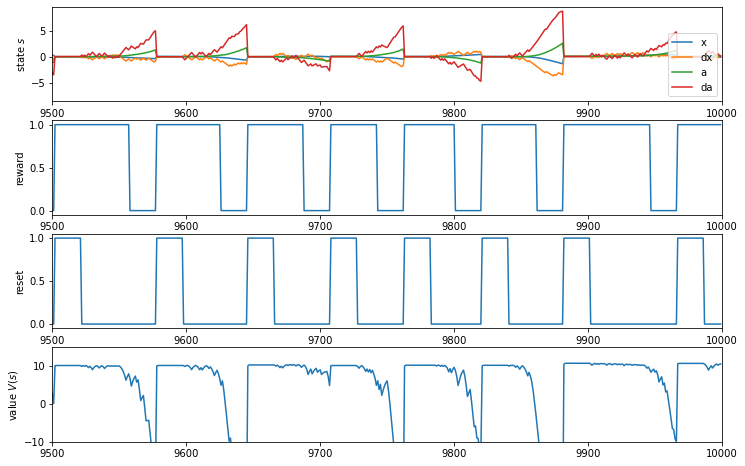

In [35]:
plt.figure(figsize=(12,8))
ax = plt.subplot(4, 1, 1)
plt.plot(r['env'][:,0], label='x')
plt.plot(r['env'][:,1], label='dx')
plt.plot(r['env'][:,2], label='a')
plt.plot(r['env'][:,3], label='da')
plt.legend()
plt.ylabel('state $s$')
plt.subplot(4, 1, 2, sharex=ax)
plt.plot(r['env'][:,4], label='reward')
plt.ylabel('reward')
plt.subplot(4, 1, 3, sharex=ax)
plt.plot(r['env'][:,5], label='reset')
plt.ylabel('reset')
plt.subplot(4, 1, 4, sharex=ax)
plt.plot(r['v'], label='value')
plt.ylim(-10, 15)
plt.ylabel('value $V(s)$')
plt.xlim(9500, 10000)
plt.show()


We're looking at the last 7 trials of the cartpole.  When the reward drops to 0, the pole has fallen over.  We let the simulation keep running a bit after that (`done_time=20`), and then reset the simulation (indicated with the reset value going to 1).  We then hold the pole still at that reset value for a while (`reset_time=20`), and then let the next trial start.

What we are hoping to see is that the value that it learns is high at the beginning of a trial, and then gradually gets worse as the pole starts falling over (remember, we don't have an Actor in this model, so it's always just randomly moving the cart, so it's going to fall pretty quickly).  So the value should drop *before* the reward drops to zero -- that would be an indication that the network has learned that states where the pole is close to falling over are bad, even though it's still getting a reward of 1.

So, that looks like it's working.  But it's really hard to see how it's doing looking at it this way.  To get a better sense of what's going on let's take all those trials and line them up on top of each other, aligned with the time that the pole fell over (i.e. when the reward dropped to 0).  I've added an option to the system to make exactly this plot (and to make 4 versions of the plot splitting the trials up over time, so we can see how it progresses).

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

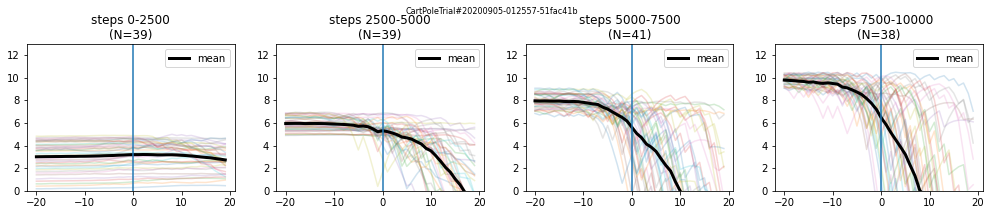

In [36]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=100, plt=True)

It's learning!  The value starts to drop before the reward does.  Now let's see if it learns more if we run it for longer.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

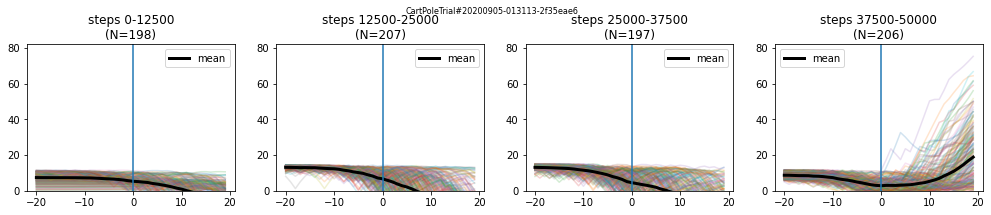

In [41]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=500, plt=True)

Um, that's bad.  Something has gone completely wrong.  My guess is that we have too high a learning rate, so we can drop that learning rate and run it for longer to see if that helps.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

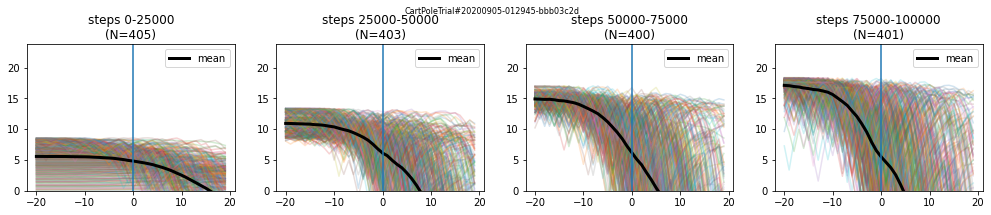

In [39]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=1000, plt=True, learning_rate=3e-5)

Well, that seems to work, and it's now noticing the pole faling over earlier, so that seems good.  I've tried adjusting a few other things (like normalizing the inputs), but that doesn't seem to affect things much.  But it does seem to require a lot of simulation runs.  

And there's also the rather concerning aspect that $V(s)$ goes _negative_.  This is very very weird, as the reward is _never_ negative, and so $V(s_t) = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ...$ really should never ever be a negative number.  So why does this network seem to think that some states have negative value?  

To me what this looks like is the network is over-generalizing.  When the weights are being changed for neurons in one state $s_1$, many of those same neurons are also active for other states like $s_2$, so adjusting what the network outputs for $V(s_1)$ will also affect $V(s_2)$.  This is also the catestrophic forgetting problem in neural networks (training in one part of the space affects what the network does in other parts of the space).  When doing backprop, the normal way to fix this is to do batch processing (or to reduce the learning rate even farther), but that's not really an option for an online learning algorithm.  

The other way of dealing with catestrophic forgetting is to make your neurons sparser -- so fewer neurons are firing for any given state, so when you adjust the weights for those neurons, you're not messing up other parts of the space, since other neurons are used there.  In a separate notebook https://github.com/neuromorphs/grill-eprop-lsnn/blob/master/rl/Using%20SSPs%20for%20sparse%20representation.ipynb I talked about how SSPs are a nice way to introduce sparsity, so let's try that.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

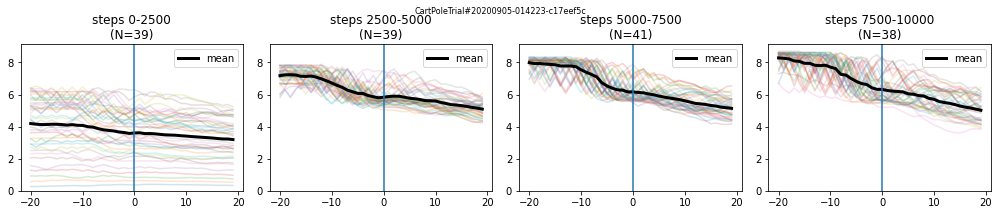

In [44]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=100, plt=True, use_ssp=True)

Hmm, that's sort of doing what we want, but still not great.  Let's adjust the `ssp_scale` (a scaling factor on the position and angle information).  Those values are pretty small, and SSPs are not great at distinguishing values much smaller than 1.  So let's scale up a bit.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

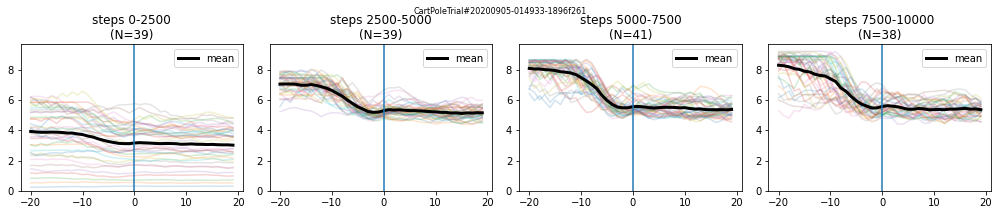

In [61]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=100, plt=True, use_ssp=True, ssp_scale=10)

Hmm, still isn't great.  But that's because we are still sampling from the entire space!  Let's do the same trick as in the other notebook and adjust our encoders to be good at the same space that we're using!

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

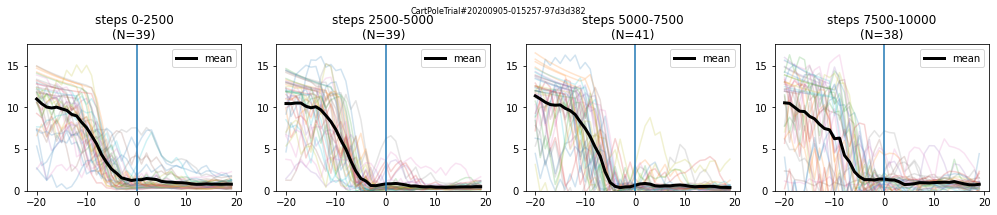

In [62]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=100, plt=True, use_ssp=True, ssp_scale=10, sample_encoders=True)

That looks perfect!  It's doing exactly what we want, and it's pretty good at knowing the value is getting worse many time steps before the pole actually falls.

Indeed, it's doing such a good job that it looks like it already has it learned in that first 39 trials.  Let's reduce the training time.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

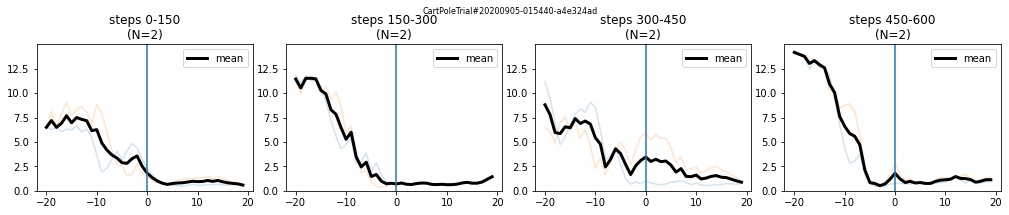

In [63]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=6, plt=True, use_ssp=True, ssp_scale=10, sample_encoders=True)

Nice.  It's learning a pretty good prediction of the value in only 8 trials!

Of course, we'd want to go do some stats on this to see how reliable it is...  be we can also adjust the random number seed and try that a few times to see how it goes.



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

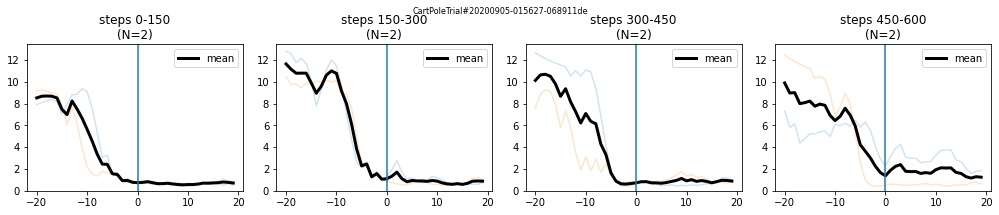

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

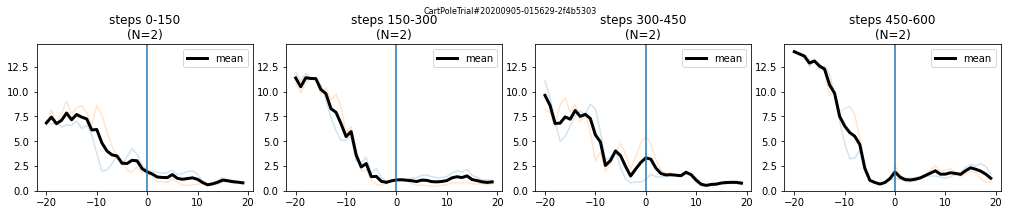

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

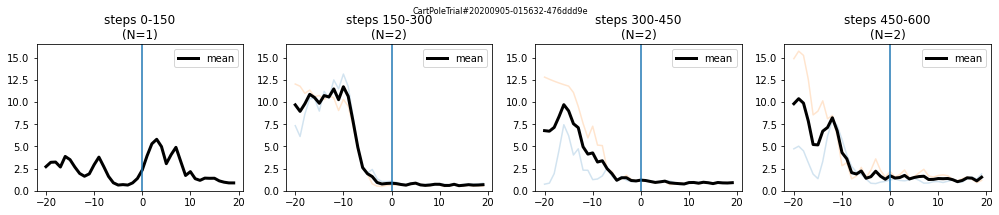

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

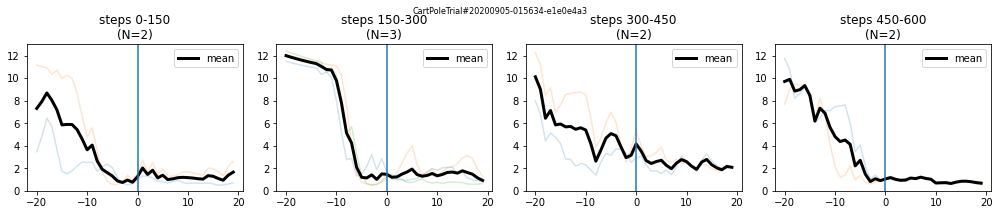

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

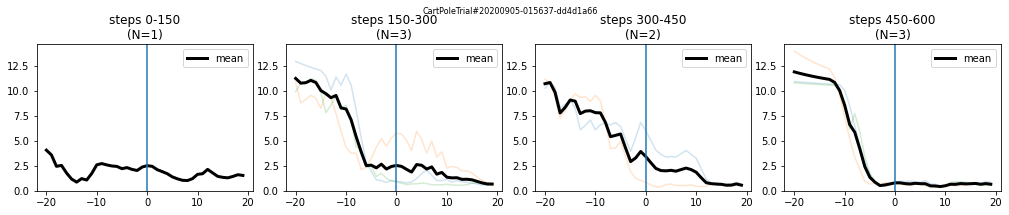

In [64]:
for seed in range(5):
    CartPoleTrial().run(data_dir=None, verbose=False, T=6, plt=True, use_ssp=True, ssp_scale=10, sample_encoders=True, 
                        seed=seed)

Looks pretty good to me!

Now the next step is to add in the Actor part of the model and see how that goes.

One other interesting thing to try would be to use an LMU for the ensemble, and only give it the position and angle information (instead of the current system, which gets position, velocity, angle, and angular velocity).